# Task 1

---

## Web scraping and analysis

This Jupyter notebook includes some code to get you started with web scraping. We will use a package called `BeautifulSoup` to collect the data from the web. Once you've collected your data and saved it into a local `.csv` file you should start with your analysis.

### Scraping data from Skytrax

If you visit [https://www.airlinequality.com] you can see that there is a lot of data there. For this task, we are only interested in reviews related to British Airways and the Airline itself.

If you navigate to this link: [https://www.airlinequality.com/airline-reviews/british-airways] you will see this data. Now, we can use `Python` and `BeautifulSoup` to collect all the links to the reviews and then to collect the text data on each of the individual review links.

In [195]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt

In [196]:
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
    
def safe_find_all_stars(tag, clas):
    f_child = tag.find('td', class_ = clas)
    return len(f_child.find_next_sibling().find_all('span', class_ = 'star fill')) if f_child else pd.NA

def safe_find_next_sibling(tag, clas):
    f_child = tag.find('td', class_ = clas)
    return f_child.find_next_sibling().get_text() if f_child else pd.NA


columns = ['name', 'header', 'time', 'text_reviow', 'Aircraft', 'Traveller', 'Seat_Type', 'Route',
           'Date_Flown', 'star_reting_aircraft', 'star_reting_Food', 'star_reting_Inflight', 'star_reting_Ground_Service',
           'star_reting_Wifi', 'star_reting_Value_For_Money', 'recommended']

review_ration_catagory = ['review-rating-header aircraft', 'review-rating-header type_of_traveller', 'review-rating-header cabin_flown', 'review-rating-header route', 'review-rating-header date_flown']
review_ration_stars = ['review-rating-header cabin_staff_service', 'review-rating-header food_and_beverages', 
'review-rating-header inflight_entertainment', 'review-rating-header ground_service', 'review-rating-header wifi_and_connectivity', 'review-rating-header value_for_money']

reviews = pd.DataFrame(columns= columns)
pages = 10
page_size = 100

In [197]:
for i in range(1, pages + 1):
    
    print(f"Scraping page {i}")

    # Create URL to collect links from paginated data
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"

    # Collect HTML data from this page
    response = requests.get(url)

    # Parse content
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')

    bodys = parsed_content.find_all("div", {"class": "body"})
    for i, body in enumerate(bodys):
        row = []
        row.append(body.find('span', itemprop = 'name').get_text())
        row.append(body.find('h2', class_ = 'text_header').get_text())
        row.append(body.find('time', itemprop = 'datePublished').get('datetime'))
        row.append(body.find('div', class_ = 'text_content').get_text())
        
        for j in review_ration_catagory:
            row.append(safe_find_next_sibling(body, j))

        for j in review_ration_stars:
            row.append(safe_find_all_stars(body, j))
        
        row.append(body.find('td', class_ = 'review-rating-header recommended').find_next_sibling('td').get_text())
        
        reviews.loc[len(reviews)] = row # type: ignore

Scraping page 1


Scraping page 2
Scraping page 3
Scraping page 4
Scraping page 5
Scraping page 6
Scraping page 7
Scraping page 8
Scraping page 9
Scraping page 10


In [198]:
reviews.head(1)

,name,header,time,text_reviow,Aircraft,Traveller,Seat_Type,Route,Date_Flown,star_reting_aircraft,star_reting_Food,star_reting_Inflight,star_reting_Ground_Service,star_reting_Wifi,star_reting_Value_For_Money,recommended
0,S Brydon,"""Great customer service""",2023-08-19,✅ Trip Verified | My family flew from Washing...,A380,Family Leisure,Economy Class,Washington to London,August 2023,5,3,2,1,<NA>,4,yes


#### Deviding Route in to two columns "From" and "To"

In [199]:
split_route = reviews['Route'].str.split(' to ', expand=True)
reviews.insert(7, 'From', split_route[0])
reviews.insert(8, 'To', split_route[1])

#### Making new column for if the tripe is Verified

In [200]:
def extract_verification(text):
    if '✅ Trip Verified | ' in text:
        return 1, text.replace('✅ Trip Verified | ', '')
    elif 'Not Verified | ' in text:
        return 0, text.replace('Not Verified | ', '')
    else:
        return None, text

reviews.insert(3, 'Verified', reviews['text_reviow'].apply(lambda x: extract_verification(x)[0]))
reviews['text_reviow'] = reviews['text_reviow'].apply(lambda x: extract_verification(x)[0])

In [201]:
reviews['Date_Flown'] = pd.to_datetime(reviews['Date_Flown'], format='%B %Y')

In [202]:
reviews.head()

,name,header,time,Verified,text_reviow,Aircraft,Traveller,Seat_Type,From,To,Route,Date_Flown,star_reting_aircraft,star_reting_Food,star_reting_Inflight,star_reting_Ground_Service,star_reting_Wifi,star_reting_Value_For_Money,recommended
0,S Brydon,"""Great customer service""",2023-08-19,1.0,1.0,A380,Family Leisure,Economy Class,Washington,London,Washington to London,2023-08-01,5,3,2,1,<NA>,4,yes
1,E Smyth,"""Cabin crew were all fantastic""",2023-08-13,1.0,1.0,A380,Family Leisure,Business Class,London,Miami,London to Miami,2023-08-01,5,5,5,4,5,4,yes
2,D Daly,"""asked us to check our bags""",2023-08-12,0.0,0.0,NaN,Family Leisure,Economy Class,London,Paris,London to Paris,2023-08-01,1,<NA>,<NA>,1,NaN,1,no
3,Karima Saci,"""service is extremely poor""",2023-08-11,0.0,0.0,NaN,Family Leisure,Economy Class,London,Algiers,London to Algiers,2023-08-01,1,1,1,1,1,1,no
4,S Deynal,"""superior to mainline British Airways""",2023-08-08,1.0,1.0,Embraer-190,Couple Leisure,Economy Class,Edinburgh,London City,Edinburgh to London City,2023-07-01,4,3,NaN,5,NaN,5,yes


### Chacking noumbers of route present in the data

In [203]:
reviews['Route'].nunique()

651

Note: found 93 out of 100 so the mostly all the Route is unique

#### Checking if the there is any difference in rating between verified tripe or not verified tripe

In [204]:
stars_columns = ['star_reting_aircraft',	'star_reting_Food', 'star_reting_Inflight',	'star_reting_Ground_Service',	'star_reting_Wifi',	'star_reting_Value_For_Money']
mean_of_stars_verified = reviews.loc[reviews['Verified']==1, stars_columns].mean ()
mean_of_stars_not_verified = reviews.loc[reviews['Verified']==0, stars_columns].mean()
mean_of_stars = reviews.loc[:, stars_columns].mean()


print('------------ Verified mean of stars ------------\n',
    verified_mean_of_stars, 
    '\n------------ Non-verified mean of stars ------------\n',
    mean_of_stars_not_verified, 
    '\n------------ Over all mean of stars ------------\n',
    mean_of_stars)


------------ Verified mean of stars ------------
 star_reting_aircraft           2.924242
star_reting_Food               2.471698
star_reting_Inflight           2.585366
star_reting_Ground_Service          2.0
star_reting_Wifi               1.964286
star_reting_Value_For_Money    1.902778
dtype: object 
------------ Non-verified mean of stars ------------
 star_reting_aircraft           3.188889
star_reting_Food               2.596154
star_reting_Inflight           2.714286
star_reting_Ground_Service     2.469945
star_reting_Wifi               1.859375
star_reting_Value_For_Money    2.263682
dtype: object 
------------ Over all mean of stars ------------
 star_reting_aircraft           3.211855
star_reting_Food               2.712121
star_reting_Inflight           2.796703
star_reting_Ground_Service      2.67619
star_reting_Wifi               2.242857
star_reting_Value_For_Money       2.447
dtype: object


There batter review from the people not verified then people are, also over all the reviews are avarige 

In [205]:
reviews.shape

(1000, 19)

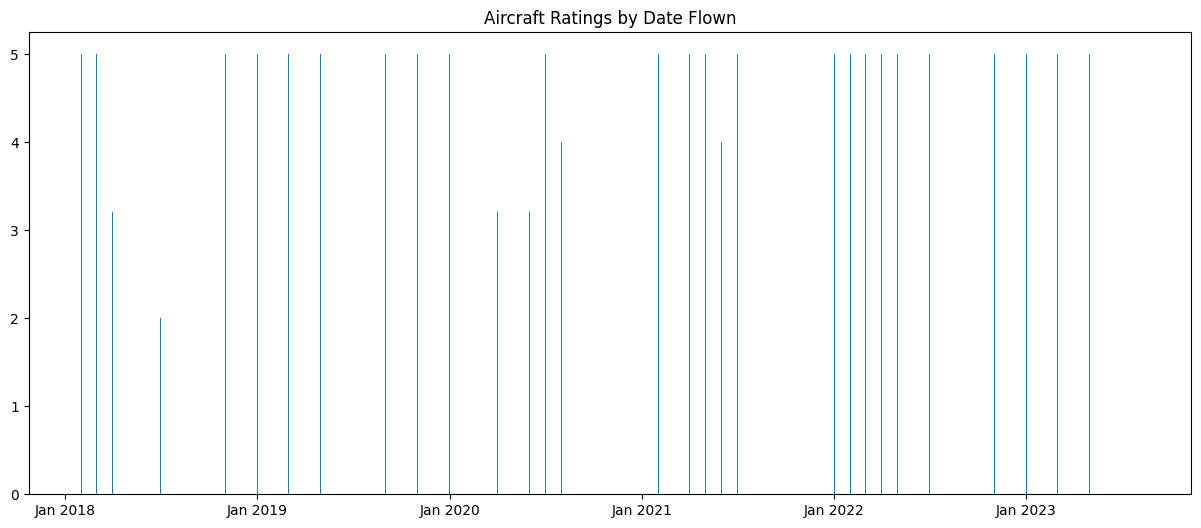

In [212]:
from matplotlib.dates import DateFormatter
plt.figure(figsize=(15, 6))
plt.bar(reviews['Date_Flown'], reviews['star_reting_aircraft'].fillna(reviews['star_reting_aircraft'].mean()))
plt.title('Aircraft Ratings by Date Flown')

date_format = DateFormatter("%b %Y")
plt.gca().xaxis.set_major_formatter(date_format)
plt.show()

In [207]:
# df.to_csv("data/BA_reviews.csv")

Congratulations! Now you have your dataset for this task! The loops above collected 1000 reviews by iterating through the paginated pages on the website. However, if you want to collect more data, try increasing the number of pages!

 The next thing that you should do is clean this data to remove any unnecessary text from each of the rows. For example, "✅ Trip Verified" can be removed from each row if it exists, as it's not relevant to what we want to investigate.